# A minimal MCNN example

Given an image of [Lenna](https://en.wikipedia.org/wiki/Lenna), we can simulate its second gradient with a [Laplace operator](https://en.wikipedia.org/wiki/Laplace_operator).

One of the ways for the simulation is an image convolution with a discrete kernel

\begin{vmatrix}
1&2&1\\
2&-12&2\\
1&2&1\\
\end{vmatrix}

This is straightforward and easy

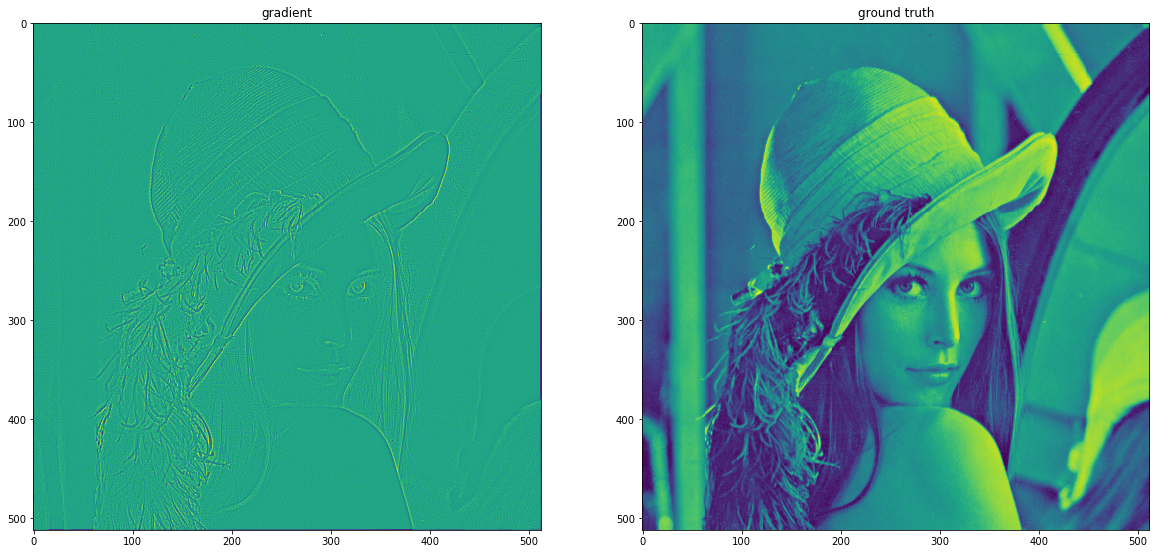

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

import tifffile
ground_truth = tifffile.imread( '../data/lena.tif')

import numpy as np
kernel = np.asarray( [[1, 2, 1], [2, -12, 2], [1, 2, 1]], dtype='float32' )
ground_truth = (ground_truth-np.amin(ground_truth))/(np.amax(ground_truth)-np.amin(ground_truth))

from scipy.signal import convolve
gradient = convolve( ground_truth, kernel, mode='same' )

fig, axs = plt.subplots(1, 2)
axs[0].set_title('gradient')
axs[0].imshow(gradient)
axs[1].set_title('ground truth')
axs[1].imshow(ground_truth)
plt.show()

The phase problem involves reconstruction the original image from its gradient.
To solve this problem with deep convolutional neural networks, first we need to check if the framework [tensorflow](https://www.tensorflow.org) has been installed or not. This can be done by

In [2]:
import tensorflow
print( tensorflow.__version__)

/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or '1type' as a synonym of 

1.13.1


Then we start to implement our MCNN model.
First we define our [kernel initializer](https://arxiv.org/abs/1502.01852) and regularizer

In [3]:
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.initializers import he_normal
kr = regularizers.l2( 1.0e-3 )
ki = he_normal()

With `kr` and `ki`, we define the classic U-Net structure

In [4]:
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers.merge import add

init = Input(shape=(512, 512, 1))
init_ = Conv2D( 32, kernel_size=(31, 31), activation = "relu", strides = 1, padding="same", kernel_regularizer=kr, kernel_initializer=ki )( init )
l1 = Conv2D( 64, kernel_size=(7, 7), activation = "relu", strides = 2, padding="same", kernel_regularizer=kr, kernel_initializer=ki )( init_ )
l2=Conv2D(128, kernel_size=(5, 5), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l1) # 128
l3=Conv2D(192, kernel_size=(3, 3), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l2) # 64
l4=Conv2D(256, kernel_size=(3, 3), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l3) # 32
l5=Conv2D(384, kernel_size=(3, 3), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l4) # 16
l6=Conv2D(512, kernel_size=(3, 3), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l5) # 8
lx1=Conv2D(768, kernel_size=(3, 3), activation="relu", strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki)(l6) # 6
lx1=Conv2D(1024, kernel_size=(3, 3), activation="relu", strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki)(lx1) # 4
lx2=Conv2D(2048, kernel_size=(3, 3), activation="relu", strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki)(lx1) # 2
lx3=Conv2DTranspose(1024, kernel_size=(3, 3), strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki, activation="relu")(lx2) # 4
lx4=add([lx3, lx1])
lx5=Conv2DTranspose(768, kernel_size=(3, 3), strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki, activation="relu")(lx4) # 6
l7=Conv2DTranspose(512, kernel_size=(3, 3), strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki, activation="relu")(lx5) # 8
l9=add([l7, l6]) #
l10=Conv2DTranspose(384, kernel_size=(3, 3), strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki, activation="relu")(l9) # 16
l12=add([l10, l5]) #
l13=Conv2DTranspose(256, kernel_size=(3, 3),  activation="relu", strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l12) # 32
l15=add([l13, l4]) #
l16=Conv2DTranspose(192, kernel_size=(3, 3), strides=(2,2), activation="relu", padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l15) # 64
l18=add([l16, l3]) #
l19=Conv2DTranspose(128, kernel_size=(3, 3), activation="relu", strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l18) # 128
l21=add([l19, l2]) #
l22=Conv2DTranspose(64, kernel_size=(3, 3), activation="relu", strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l21) # 256
l24=add([l22, l1])
l25=Conv2DTranspose(32, kernel_size=(3, 3), activation="relu", strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l24) # 512
l27=add([l25, init_])
llast=Conv2D(16 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l27)
llast=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(llast)
last512=Conv2D(1, kernel_size=(31, 31), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_512")(llast)
#unet = Model( init, last512 )

Instructions for updating:
Colocations handled automatically by placer.


MCNN epxands the layers in the decoder to match low-frequency components. The expanded layers can be defined this way to make a model

In [5]:
last4=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(lx4)
last4=Conv2D(1, kernel_size=(3, 3), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_4")(last4)

last8=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l9)
last8=Conv2D(1, kernel_size=(5, 5), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_8")(last8)

last16=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l12)
last16=Conv2D(1, kernel_size=(5, 5), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_16")(last16)

last32=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l15)
last32=Conv2D(1, kernel_size=(7, 7), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_32")(last32)

last64=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l18)
last64=Conv2D(1, kernel_size=(9, 9), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_64")(last64)

last128=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l21)
last128=Conv2D(1, kernel_size=(11, 11), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_128")(last128)

last256=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l24)
last256=Conv2D(1, kernel_size=(17, 17), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_256")(last256)

mcnn = Model(inputs=init, outputs=[last512, last256, last128, last64, last32, last16, last8, last4])
mcnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 30784       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 100416      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 128 204928      conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

With 2 GPUs, we make the training plan using [Adam](https://arxiv.org/abs/1412.6980) minimizing the mean absolute errros

In [6]:
from tensorflow.python.keras.utils import multi_gpu_model
mcnn = multi_gpu_model( mcnn, gpus=2 )
mcnn.compile( loss='mae', optimizer='adam' )

The low frequency components data can be generated by pooling the original images sequencially. This is done by

In [7]:
from skimage.measure import block_reduce
def make_block_reduce( input_layers, dim=(2,2), mode=np.mean ):
    stacked_layers = [ block_reduce( image, dim, mode ) for image in input_layers ]
    return np.asarray( stacked_layers, dtype='float32' )

Then by simulating the gradient images from some existing image set, for example [ImageNet](http://www.image-net.org/), we can prepare a training/validation dataset with 1024 samples this way

In [8]:
import glob
paths = glob.glob( '/raid/feng/pictures/openimagenet.v5/*.jpg')

import random    
random.shuffle( paths )

shape = (512, 512)
number = 1024
gaussian_noise_var = 0.01

from imageio import imread
def trim_image_from_path( image_path, shape ):
    try:
        image = imread( image_path )
    except:
        return None
    image = np.asarray( image, dtype='float32' )
    image = image / 255.0

    if 3 == len(image.shape): # rgb -> gray
        image = 0.2627*image[:,:,0]+0.6780*image[:,:,1]+0.0593*image[:,:,2]

    scaling_ratio = [ int(a/b) for a, b in zip( image.shape, shape ) ]
    if scaling_ratio[0] > 1 and scaling_ratio[1] > 1 :
        image = block_reduce( image, tuple(scaling_ratio), np.mean )

    dim_diff = [ (a - b)>>1 for a, b in zip( image.shape, shape ) ]
    if dim_diff[0] < 0 or dim_diff[1] < 0:
        return None
    return image[dim_diff[0]:dim_diff[0]+shape[0], dim_diff[1]:dim_diff[1]+shape[1]]

output_images = []
input_images = []
counter = 0
for path in paths:
    trimmed_image = trim_image_from_path(path, shape )
    if trimmed_image is not None:
        print( f'preparing training set from {path} - {counter}/{number}', end='\r' )
        output_images.append(trimmed_image)
        input_images.append( convolve( trimmed_image, kernel, mode='same' ) )
        counter += 1
    if counter == number:
        break

input_layers = np.asarray( input_images, dtype='float32' ).reshape( (number,)+shape+(1,) )
input_layers += np.random.normal(loc=0.0, scale=gaussian_noise_var, size=input_layers.shape)

output_layers = [np.asarray( output_images, dtype='float32' ), None, None, None, None, None, None, None]
for idx in range( 7 ):
    output_layers[idx+1] = make_block_reduce( output_layers[idx], (2,2), np.mean )
    output_layers[idx] = output_layers[idx].reshape( output_layers[idx].shape + (1,) )
output_layers[7] = output_layers[7].reshape( output_layers[7].shape + (1,) )

/usr/lib/python3.7/site-packages/skimage/util/shape.py:93: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


/usr/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18481152 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33619968 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 31197188 bytes but only got 0. Skipping tag 1029
  " Skipping tag %s" % (size, len(data), tag)
/usr/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnin

The gradient and the ground truth for the first image-pair are visualized below

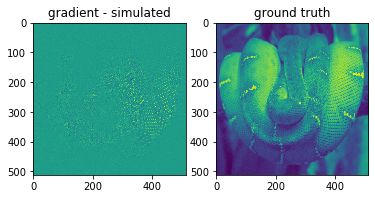

In [9]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title('gradient - simulated')
axs[0].imshow(np.squeeze(input_layers[0]))
axs[1].set_title('ground truth')
axs[1].imshow(np.squeeze(output_layers[0][0]))
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

For demonstration, we train the model 128 epochs with a batch size of 8 and a validation split of 1/4. In actural applications, the epochs and the size of the training set should be much larger.

In [10]:
mcnn.fit( input_layers, output_layers, batch_size=8, epochs=128, verbose=1,validation_split=0.25 )

Train on 768 samples, validate on 256 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/128
768/768 [==============================] - 68s 89ms/sample - loss: 22.9138 - gen_512_loss: 1.8086 - gen_256_loss: 1.8047 - gen_128_loss: 1.7740 - gen_64_loss: 1.7253 - gen_32_loss: 1.6680 - gen_16_loss: 1.5763 - gen_8_loss: 1.4675 - gen_4_loss: 1.2939 - val_loss: 16.8368 - val_gen_512_loss: 1.7255 - val_gen_256_loss: 1.7470 - val_gen_128_loss: 1.7458 - val_gen_64_loss: 1.6836 - val_gen_32_loss: 1.6195 - val_gen_16_loss: 1.5209 - val_gen_8_loss: 1.3891 - val_gen_4_loss: 1.2056
Epoch 2/128
768/768 [==============================] - 57s 75ms/sample - loss: 14.7417 - gen_512_loss: 1.6032 - gen_256_loss: 1.6578 - gen_128_loss: 1.6841 - gen_64_loss: 1.5856 - gen_32_loss: 1.5239 - gen_16_loss: 1.4321 - gen_8_loss: 1.3197 - gen_4_loss: 1.1928 - val_loss: 12.6088 - val_gen_512_loss: 1.3930 - val_gen_256_loss: 1.5828 - val_gen_128_loss: 1.5837 - val_gen_64_loss: 1.4387 - val_gen_32_loss: 1.3

768/768 [==============================] - 64s 84ms/sample - loss: 5.4513 - gen_512_loss: 0.6513 - gen_256_loss: 0.7350 - gen_128_loss: 0.6949 - gen_64_loss: 0.6553 - gen_32_loss: 0.6166 - gen_16_loss: 0.5771 - gen_8_loss: 0.5436 - gen_4_loss: 0.5523 - val_loss: 5.3270 - val_gen_512_loss: 0.6355 - val_gen_256_loss: 0.7005 - val_gen_128_loss: 0.6623 - val_gen_64_loss: 0.6298 - val_gen_32_loss: 0.5975 - val_gen_16_loss: 0.5653 - val_gen_8_loss: 0.5398 - val_gen_4_loss: 0.5672
Epoch 18/128
768/768 [==============================] - 65s 85ms/sample - loss: 5.1440 - gen_512_loss: 0.6211 - gen_256_loss: 0.6942 - gen_128_loss: 0.6541 - gen_64_loss: 0.6164 - gen_32_loss: 0.5753 - gen_16_loss: 0.5361 - gen_8_loss: 0.5037 - gen_4_loss: 0.5136 - val_loss: 5.4388 - val_gen_512_loss: 0.6371 - val_gen_256_loss: 0.7068 - val_gen_128_loss: 0.6663 - val_gen_64_loss: 0.6313 - val_gen_32_loss: 0.6000 - val_gen_16_loss: 0.5740 - val_gen_8_loss: 0.5740 - val_gen_4_loss: 0.6136
Epoch 19/128
768/768 [=======

Epoch 34/128
768/768 [==============================] - 66s 86ms/sample - loss: 3.7022 - gen_512_loss: 0.4400 - gen_256_loss: 0.5033 - gen_128_loss: 0.4609 - gen_64_loss: 0.4250 - gen_32_loss: 0.3887 - gen_16_loss: 0.3572 - gen_8_loss: 0.3217 - gen_4_loss: 0.3121 - val_loss: 4.6215 - val_gen_512_loss: 0.5202 - val_gen_256_loss: 0.5878 - val_gen_128_loss: 0.5548 - val_gen_64_loss: 0.5296 - val_gen_32_loss: 0.5025 - val_gen_16_loss: 0.4783 - val_gen_8_loss: 0.4628 - val_gen_4_loss: 0.4921
Epoch 35/128
768/768 [==============================] - 65s 85ms/sample - loss: 3.5814 - gen_512_loss: 0.4210 - gen_256_loss: 0.4847 - gen_128_loss: 0.4438 - gen_64_loss: 0.4107 - gen_32_loss: 0.3747 - gen_16_loss: 0.3451 - gen_8_loss: 0.3084 - gen_4_loss: 0.2991 - val_loss: 4.7980 - val_gen_512_loss: 0.5555 - val_gen_256_loss: 0.6181 - val_gen_128_loss: 0.5887 - val_gen_64_loss: 0.5483 - val_gen_32_loss: 0.5286 - val_gen_16_loss: 0.4980 - val_gen_8_loss: 0.4769 - val_gen_4_loss: 0.4888
Epoch 36/128
768

Epoch 51/128
768/768 [==============================] - 66s 86ms/sample - loss: 3.4841 - gen_512_loss: 0.4186 - gen_256_loss: 0.4636 - gen_128_loss: 0.4226 - gen_64_loss: 0.3906 - gen_32_loss: 0.3623 - gen_16_loss: 0.3323 - gen_8_loss: 0.3006 - gen_4_loss: 0.2767 - val_loss: 4.6078 - val_gen_512_loss: 0.5196 - val_gen_256_loss: 0.5739 - val_gen_128_loss: 0.5443 - val_gen_64_loss: 0.5212 - val_gen_32_loss: 0.5011 - val_gen_16_loss: 0.4854 - val_gen_8_loss: 0.4599 - val_gen_4_loss: 0.4827
Epoch 52/128
768/768 [==============================] - 64s 84ms/sample - loss: 3.3583 - gen_512_loss: 0.3894 - gen_256_loss: 0.4473 - gen_128_loss: 0.4078 - gen_64_loss: 0.3756 - gen_32_loss: 0.3457 - gen_16_loss: 0.3188 - gen_8_loss: 0.2845 - gen_4_loss: 0.2680 - val_loss: 4.5769 - val_gen_512_loss: 0.5197 - val_gen_256_loss: 0.5709 - val_gen_128_loss: 0.5393 - val_gen_64_loss: 0.5151 - val_gen_32_loss: 0.4974 - val_gen_16_loss: 0.4798 - val_gen_8_loss: 0.4577 - val_gen_4_loss: 0.4754
Epoch 53/128
768

Epoch 68/128
768/768 [==============================] - 65s 85ms/sample - loss: 2.9307 - gen_512_loss: 0.3387 - gen_256_loss: 0.3884 - gen_128_loss: 0.3507 - gen_64_loss: 0.3193 - gen_32_loss: 0.2938 - gen_16_loss: 0.2680 - gen_8_loss: 0.2367 - gen_4_loss: 0.2153 - val_loss: 4.8789 - val_gen_512_loss: 0.5712 - val_gen_256_loss: 0.6068 - val_gen_128_loss: 0.5858 - val_gen_64_loss: 0.5675 - val_gen_32_loss: 0.5427 - val_gen_16_loss: 0.5168 - val_gen_8_loss: 0.4847 - val_gen_4_loss: 0.4819
Epoch 69/128
768/768 [==============================] - 66s 87ms/sample - loss: 2.9739 - gen_512_loss: 0.3418 - gen_256_loss: 0.3914 - gen_128_loss: 0.3546 - gen_64_loss: 0.3238 - gen_32_loss: 0.2982 - gen_16_loss: 0.2742 - gen_8_loss: 0.2428 - gen_4_loss: 0.2240 - val_loss: 4.4420 - val_gen_512_loss: 0.5002 - val_gen_256_loss: 0.5460 - val_gen_128_loss: 0.5168 - val_gen_64_loss: 0.4958 - val_gen_32_loss: 0.4801 - val_gen_16_loss: 0.4663 - val_gen_8_loss: 0.4482 - val_gen_4_loss: 0.4660
Epoch 70/128
768

Epoch 85/128
768/768 [==============================] - 66s 86ms/sample - loss: 2.7782 - gen_512_loss: 0.3145 - gen_256_loss: 0.3617 - gen_128_loss: 0.3261 - gen_64_loss: 0.2972 - gen_32_loss: 0.2753 - gen_16_loss: 0.2529 - gen_8_loss: 0.2237 - gen_4_loss: 0.2042 - val_loss: 4.6810 - val_gen_512_loss: 0.6002 - val_gen_256_loss: 0.5881 - val_gen_128_loss: 0.5445 - val_gen_64_loss: 0.5176 - val_gen_32_loss: 0.4981 - val_gen_16_loss: 0.4756 - val_gen_8_loss: 0.4621 - val_gen_4_loss: 0.4722
Epoch 86/128
768/768 [==============================] - 66s 86ms/sample - loss: 2.7312 - gen_512_loss: 0.3092 - gen_256_loss: 0.3554 - gen_128_loss: 0.3209 - gen_64_loss: 0.2911 - gen_32_loss: 0.2687 - gen_16_loss: 0.2481 - gen_8_loss: 0.2174 - gen_4_loss: 0.1974 - val_loss: 4.2980 - val_gen_512_loss: 0.4784 - val_gen_256_loss: 0.5237 - val_gen_128_loss: 0.4978 - val_gen_64_loss: 0.4755 - val_gen_32_loss: 0.4648 - val_gen_16_loss: 0.4507 - val_gen_8_loss: 0.4336 - val_gen_4_loss: 0.4511
Epoch 87/128
768

Epoch 102/128
768/768 [==============================] - 68s 89ms/sample - loss: 2.7421 - gen_512_loss: 0.3098 - gen_256_loss: 0.3519 - gen_128_loss: 0.3184 - gen_64_loss: 0.2914 - gen_32_loss: 0.2704 - gen_16_loss: 0.2488 - gen_8_loss: 0.2204 - gen_4_loss: 0.1976 - val_loss: 4.4064 - val_gen_512_loss: 0.4988 - val_gen_256_loss: 0.5253 - val_gen_128_loss: 0.5023 - val_gen_64_loss: 0.4869 - val_gen_32_loss: 0.4783 - val_gen_16_loss: 0.4654 - val_gen_8_loss: 0.4450 - val_gen_4_loss: 0.4724
Epoch 103/128
768/768 [==============================] - 66s 86ms/sample - loss: 2.5535 - gen_512_loss: 0.2852 - gen_256_loss: 0.3282 - gen_128_loss: 0.2944 - gen_64_loss: 0.2666 - gen_32_loss: 0.2454 - gen_16_loss: 0.2263 - gen_8_loss: 0.1972 - gen_4_loss: 0.1800 - val_loss: 4.4366 - val_gen_512_loss: 0.5244 - val_gen_256_loss: 0.5383 - val_gen_128_loss: 0.5132 - val_gen_64_loss: 0.4909 - val_gen_32_loss: 0.4805 - val_gen_16_loss: 0.4684 - val_gen_8_loss: 0.4399 - val_gen_4_loss: 0.4526
Epoch 104/128


Epoch 119/128
768/768 [==============================] - 65s 84ms/sample - loss: 2.5196 - gen_512_loss: 0.2827 - gen_256_loss: 0.3209 - gen_128_loss: 0.2895 - gen_64_loss: 0.2628 - gen_32_loss: 0.2433 - gen_16_loss: 0.2234 - gen_8_loss: 0.1969 - gen_4_loss: 0.1757 - val_loss: 4.4213 - val_gen_512_loss: 0.5012 - val_gen_256_loss: 0.5302 - val_gen_128_loss: 0.5083 - val_gen_64_loss: 0.4925 - val_gen_32_loss: 0.4804 - val_gen_16_loss: 0.4707 - val_gen_8_loss: 0.4512 - val_gen_4_loss: 0.4628
Epoch 120/128
768/768 [==============================] - 67s 87ms/sample - loss: 2.5269 - gen_512_loss: 0.2871 - gen_256_loss: 0.3213 - gen_128_loss: 0.2899 - gen_64_loss: 0.2632 - gen_32_loss: 0.2440 - gen_16_loss: 0.2240 - gen_8_loss: 0.1966 - gen_4_loss: 0.1769 - val_loss: 4.2571 - val_gen_512_loss: 0.4887 - val_gen_256_loss: 0.5086 - val_gen_128_loss: 0.4857 - val_gen_64_loss: 0.4679 - val_gen_32_loss: 0.4571 - val_gen_16_loss: 0.4474 - val_gen_8_loss: 0.4272 - val_gen_4_loss: 0.4508
Epoch 121/128


The training will take quite a while depending on the hardware.

After training, we can make a prediction to test

In [11]:
prediction, *_ = mcnn.predict( gradient.reshape((1,)+gradient.shape+(1,)))
prediction = np.squeeze( prediction )

Now we can compare the ground truth and the prediction

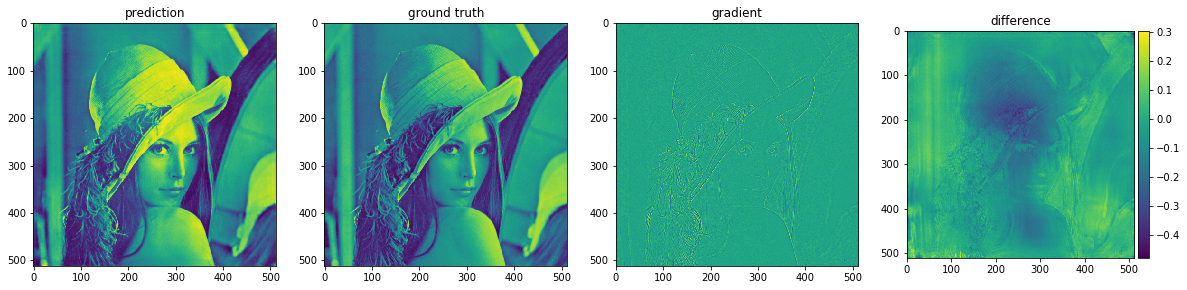

MAE is 0.06797673713645039


In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1, 4)
axs[0].set_title('prediction')
axs[0].imshow(prediction)
axs[1].set_title('ground truth')
axs[1].imshow(ground_truth)
axs[2].set_title('gradient')
axs[2].imshow(gradient)
ground_truth = (ground_truth-np.amin(ground_truth))/(np.amax(ground_truth)-np.amin(ground_truth)+1.0e-10)
prediction = (prediction-np.amin(prediction))/(np.amax(prediction)-np.amin(prediction)+1.0e-10)
diff = ground_truth - prediction
axs[3].set_title('difference')
im = axs[3].imshow(diff)
divider = make_axes_locatable(axs[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

print( f'MAE is {np.sum(np.abs(diff))/(512*512)}' )


We can compare its performance with a conventional U-Net model.

In [13]:
init = Input(shape=(512, 512, 1))
init_ = Conv2D( 32, kernel_size=(31, 31), activation = "relu", strides = 1, padding="same", kernel_regularizer=kr, kernel_initializer=ki )( init )
l1 = Conv2D( 64, kernel_size=(7, 7), activation = "relu", strides = 2, padding="same", kernel_regularizer=kr, kernel_initializer=ki )( init_ )
l2=Conv2D(128, kernel_size=(5, 5), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l1) # 128
l3=Conv2D(192, kernel_size=(3, 3), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l2) # 64
l4=Conv2D(256, kernel_size=(3, 3), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l3) # 32
l5=Conv2D(384, kernel_size=(3, 3), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l4) # 16
l6=Conv2D(512, kernel_size=(3, 3), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l5) # 8
lx1=Conv2D(768, kernel_size=(3, 3), activation="relu", strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki)(l6) # 6
lx1=Conv2D(1024, kernel_size=(3, 3), activation="relu", strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki)(lx1) # 4
lx2=Conv2D(2048, kernel_size=(3, 3), activation="relu", strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki)(lx1) # 2
lx3=Conv2DTranspose(1024, kernel_size=(3, 3), strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki, activation="relu")(lx2) # 4
lx4=add([lx3, lx1])
lx5=Conv2DTranspose(768, kernel_size=(3, 3), strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki, activation="relu")(lx4) # 6
l7=Conv2DTranspose(512, kernel_size=(3, 3), strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki, activation="relu")(lx5) # 8
l9=add([l7, l6]) #
l10=Conv2DTranspose(384, kernel_size=(3, 3), strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki, activation="relu")(l9) # 16
l12=add([l10, l5]) #
l13=Conv2DTranspose(256, kernel_size=(3, 3),  activation="relu", strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l12) # 32
l15=add([l13, l4]) #
l16=Conv2DTranspose(192, kernel_size=(3, 3), strides=(2,2), activation="relu", padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l15) # 64
l18=add([l16, l3]) #
l19=Conv2DTranspose(128, kernel_size=(3, 3), activation="relu", strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l18) # 128
l21=add([l19, l2]) #
l22=Conv2DTranspose(64, kernel_size=(3, 3), activation="relu", strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l21) # 256
l24=add([l22, l1])
l25=Conv2DTranspose(32, kernel_size=(3, 3), activation="relu", strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l24) # 512
l27=add([l25, init_])
llast=Conv2D(16 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l27)
llast=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(llast)
last512=Conv2D(1, kernel_size=(31, 31), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_512")(llast)
unet = Model( init, last512 )

With this model, we train it 128 epochs with a batch size of 8 and a validation split of 1/4, a same configuration as mcnn model.

In [16]:
unet = multi_gpu_model( unet, gpus=2 )
unet.compile( loss='mae', optimizer='adam' )
unet.fit( input_layers, output_layers[0], batch_size=8, epochs=128, verbose=1,validation_split=0.25 )

Train on 768 samples, validate on 256 samples
Epoch 1/128
768/768 [==============================] - 77s 100ms/sample - loss: 4.7525 - val_loss: 1.8423
Epoch 2/128
768/768 [==============================] - 64s 83ms/sample - loss: 1.7130 - val_loss: 1.6930
Epoch 3/128
768/768 [==============================] - 68s 88ms/sample - loss: 1.5201 - val_loss: 1.4933
Epoch 4/128
768/768 [==============================] - 74s 97ms/sample - loss: 1.3927 - val_loss: 1.3694
Epoch 5/128
768/768 [==============================] - 73s 95ms/sample - loss: 1.3395 - val_loss: 1.2805
Epoch 6/128
768/768 [==============================] - 72s 93ms/sample - loss: 1.2768 - val_loss: 1.2372
Epoch 7/128
768/768 [==============================] - 71s 93ms/sample - loss: 1.2584 - val_loss: 1.2071
Epoch 8/128
768/768 [==============================] - 72s 94ms/sample - loss: 1.2048 - val_loss: 1.2301
Epoch 9/128
768/768 [==============================] - 71s 92ms/sample - loss: 1.2142 - val_loss: 1.2500
Epoch 10

Epoch 78/128
768/768 [==============================] - 69s 90ms/sample - loss: 1.0003 - val_loss: 1.0352
Epoch 79/128
768/768 [==============================] - 68s 89ms/sample - loss: 0.9836 - val_loss: 1.0829
Epoch 80/128
768/768 [==============================] - 68s 88ms/sample - loss: 0.9910 - val_loss: 1.0338
Epoch 81/128
768/768 [==============================] - 70s 92ms/sample - loss: 1.0015 - val_loss: 1.0392
Epoch 82/128
768/768 [==============================] - 71s 92ms/sample - loss: 0.9920 - val_loss: 1.0312
Epoch 83/128
768/768 [==============================] - 70s 91ms/sample - loss: 0.9937 - val_loss: 1.0159
Epoch 84/128
768/768 [==============================] - 70s 92ms/sample - loss: 0.9807 - val_loss: 1.0367
Epoch 85/128
768/768 [==============================] - 69s 90ms/sample - loss: 0.9819 - val_loss: 1.0377
Epoch 86/128
768/768 [==============================] - 71s 93ms/sample - loss: 0.9745 - val_loss: 1.0248
Epoch 87/128
768/768 [========================

Then we can make predictions using U-Net model

In [17]:
prediction_, *_ = unet.predict( gradient.reshape((1,)+gradient.shape+(1,)))
prediction_ = np.squeeze( prediction_ )

Now we can compare the ground truth and the prediction from unet

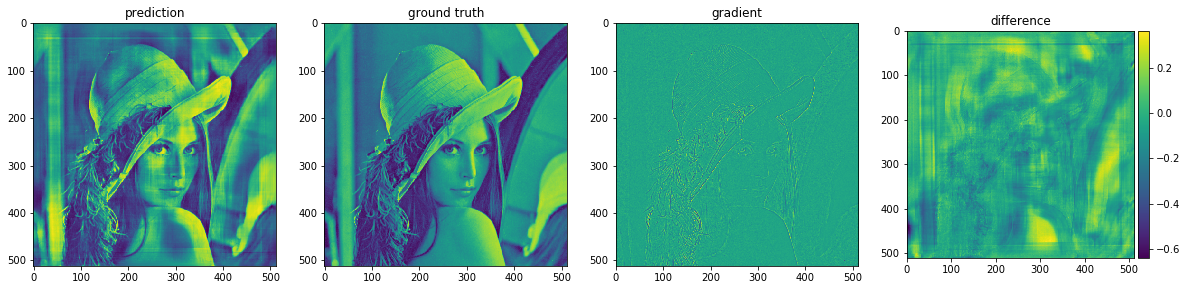

MAE is 0.08289105537011324


In [18]:
fig, axs = plt.subplots(1, 4)
axs[0].set_title('prediction')
axs[0].imshow(prediction_)
axs[1].set_title('ground truth')
axs[1].imshow(ground_truth)
axs[2].set_title('gradient')
axs[2].imshow(gradient)
ground_truth = (ground_truth-np.amin(ground_truth))/(np.amax(ground_truth)-np.amin(ground_truth)+1.0e-10)
prediction_ = (prediction_-np.amin(prediction_))/(np.amax(prediction_)-np.amin(prediction_)+1.0e-10)
diff = ground_truth - prediction_
axs[3].set_title('difference')
im = axs[3].imshow(diff)
divider = make_axes_locatable(axs[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

print( f'MAE is {np.sum(np.abs(diff))/(512*512)}' )

And the we can put the prediction results from MCNN and UNET together for a visual comparision

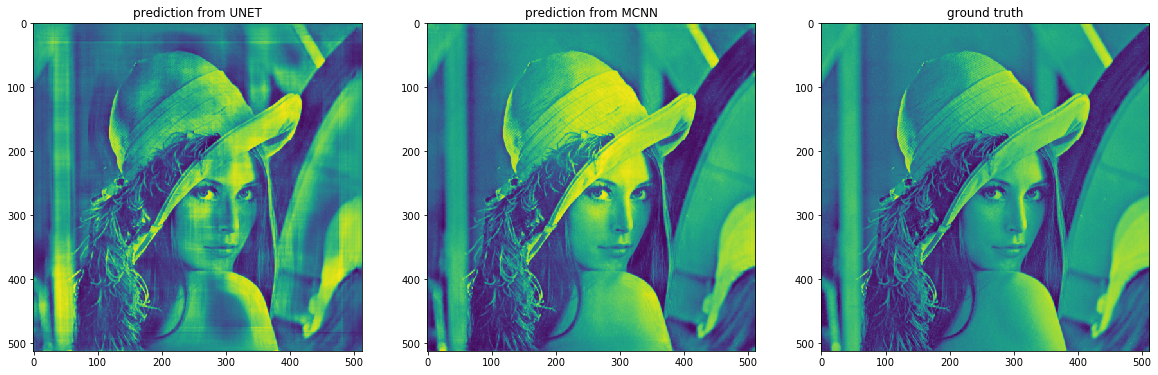

In [19]:
fig, axs = plt.subplots(1, 3)
axs[0].set_title('prediction from UNET')
axs[0].imshow(prediction_)
axs[1].set_title('prediction from MCNN')
axs[1].imshow(prediction)
axs[2].set_title('ground truth')
axs[2].imshow(ground_truth)
plt.rcParams["figure.figsize"] = (20,10)
plt.show()